In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import tqdm
import glob
import subprocess

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

# Functions

In [124]:
import xrft
import subprocess

def fourier_truncate(ds,truncate=0.3):
    
    """
    Spectral truncation of data using FT.
    truncate = truncation level in maximum allowed frequency per degree
    """
    
    # fft
    ds_fft = xrft.fft(ds,dim=['latitude','longitude'],true_phase=True,true_amplitude=True)

    # truncate
    ds_fft = ds_fft.where(np.sqrt(ds_fft.freq_longitude**2+ds_fft.freq_latitude**2)<truncate,0)

    # invert
    ds_ifft = xrft.ifft(ds_fft,dim=['freq_longitude','freq_latitude'],true_phase=True,true_amplitude=True)

    return ds_ifft


def truncate_and_save(fpath,add_msl=True, base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/'):
    '''
    Function to truncate and save data for Tempest Extremes 
    storm tracking.
    Written by Nick Leach.

    Parameters
    ----------  
    fpath : str
        Path to the data file.
    add_msl : bool
        If True, the function will also load the mean sea level pressure data.  
    base_dir : str
        Path to the directory where the data will be saved.

    Returns
    -------
    None
    '''
    
    ds_fname = fpath.split('/')[-1].split('.')[0]
    
    ds = xr.open_dataset(fpath)
    print('loaded pl data',flush=True)
    ds = ds.vo.sel(level=850,time=(ds.time.dt.hour%3)==0)
    ds = ds.sel(time=slice('2023-10-11','2023-10-23'))
    print('truncating vo data',flush=True)
    ds_trunc = fourier_truncate(ds).sortby('latitude',ascending=False)
    print('truncated vo data',flush=True)
    
    if add_msl:
        ds = xr.open_dataset(fpath.replace('/pl/','/sfc/')).get(['msl'])
        ds = ds.sel(time=ds_trunc.time)
        print('loaded msl data',flush=True)
        
        if 'number' in ds.coords:
            ds['vo'] = (('time','number','latitude','longitude'),ds_trunc.real.values)
            print('saving member files',flush=True)
            [ds.sel(number=x).to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,x)) for x in ds.number.values]
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,x) for x in ds.number.values]
        else:
            ds['vo'] = (('time','latitude','longitude'),ds_trunc.real.values)
            print('saving control file',flush=True)
            ds.to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,0))
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,0)]
    else:
        if 'number' in ds.coords:
            [ds_trunc.real.sel(number=x).to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,x)) for x in ds.number.values]
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,x) for x in ds.number.values]
        else:
            ds_trunc.real.to_netcdf(base_dir+'TEin_{}_{}.nc'.format(ds_fname,0))
            in_paths = [base_dir+'TEin_{}_{}.nc'.format(ds_fname,0)]
                
    with open(base_dir+'TE_nc_in_list.txt','w') as f:
        f.writelines([x+'\n' for x in in_paths])
    with open(base_dir+'TE_DN_out.txt','w') as f:
        f.writelines([x.replace('TEin','TENodes').replace('.nc','')+'\n' for x in in_paths])
        

def run_TE(fpath, base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/'):
    '''
    Function to run Tempest Extremes storm tracking.
    Written by Nick Leach.

    Parameters
    ----------
    fpath : str
        Path to the data file.
    base_dir : str
        Path to the directory where the data will be saved.

    Returns
    -------
    None
    '''
    
    truncate_and_save(fpath)
    
    print('Node detection across files',flush=True)

    DetectNodes_args = []
    DetectNodes_args += ['DetectNodes']
    DetectNodes_args += ['--in_data_list', base_dir+'TE_nc_in_list.txt']
    DetectNodes_args += ['--out_file_list', base_dir+'TE_DN_out.txt']
    DetectNodes_args += ['--closedcontourcmd','msl,300,6.0,0']
    DetectNodes_args += ['--thresholdcmd','vo,>,0.0002,4.0']
    DetectNodes_args += ['--mergedist','2.0']
    DetectNodes_args += ['--searchbymin','msl']
    DetectNodes_args += ['--outputcmd','msl,min,3;vo,max,0']
    DetectNodes_args += ['--timefilter','3hr']
    DetectNodes_args += ['--latname','latitude']
    DetectNodes_args += ['--lonname','longitude']
    DetectNodes_args += ['--regional']
    
    DN_out = subprocess.run(DetectNodes_args,stdout=subprocess.PIPE)
    
    print('Node stitching across files',flush=True)

    with open(base_dir+'TE_DN_out.txt','r') as f:
        nodefiles = [x.strip() for x in f.readlines()]
        
    for nodefile in nodefiles:
    
        StitchNodes_args = []
        StitchNodes_args += ['StitchNodes']

        StitchNodes_args += ['--in_fmt','lon,lat,msl,vo']
        StitchNodes_args += ['--in',nodefile]
        StitchNodes_args += ['--out',nodefile.replace('TENodes','TEStitch')]
        StitchNodes_args += ['--range','7.0']
        StitchNodes_args += ['--mintime','24h']
        StitchNodes_args += ['--maxgap','48h']
        StitchNodes_args += ['--min_endpoint_dist','12.0']
        StitchNodes_args += ['--out_file_format','csv']
    
        SN_out = subprocess.run(StitchNodes_args,stdout=subprocess.PIPE)


def read_nodes(fpath):
    '''
    Function to read in the nodes from the Tempest Extremes output.
    Written by Nick Leach.

    Parameters
    ----------
    fpath : str
        Path to the data file.

    Returns
    -------
    pd.DataFrame
        Dataframe containing the nodes (lon, lat, pmin, vomax, date).
    '''
    
    with open(fpath,'r') as f:
        lines = f.readlines()

    readout = []
    for line in lines:

        if line[:1] != '\t':
            year,mon,day,num,hr = line.replace('\n','').split('\t')
            date = pd.to_datetime('{:04d}-{:02d}-{:02d} {:02d}'.format(int(year),int(mon),int(day),int(hr)))
        else:
            _,idxlon,idxlat,lon,lat,p_min,vo_max = line.replace('\n','').split('\t')
            readout += [[float(lon),float(lat),float(p_min),float(vo_max),date]]
            
    return pd.DataFrame(data=readout,columns=['lon','lat','p_min','vo_max','date'])

# Tracking

In [125]:
# ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
# ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

In [126]:
# # check whether the variable field_in is already open
# if 'field_in' in globals().keys(): 
#     field_in.close()

# # open the file and run TE
# for fpath in tqdm.tqdm(glob.glob('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/EU025/pl/pf/*2023-10-15.nc')):
#     print(fpath)
#     run_TE(fpath)
#     [os.remove(x) for x in glob.glob('/home/e/ermis/Storm_Babet/data/tracking/TE/*2023-10-15*.nc')]

In [127]:
# Track storm in ERA
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/tracks/'
fpath = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/2023.nc'
run_TE(fpath) # only needs to be run once
fname = fpath.split('/')[-1].split('.')[0]
tracks_out = pd.read_csv(base_dir+'TEStitch_{}_0'.format(fname),skipinitialspace=True)
tracks_out['date'] = pd.to_datetime(tracks_out[['year','month','day','hour']])
nodes_out = read_nodes(base_dir+'TENodes_{}_0'.format(fname))
field_in = xr.open_dataset(base_dir+'TEin_{}_0.nc'.format(fname))

loaded pl data
truncating vo data


/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


truncated vo data
loaded msl data
saving control file
Node detection across files
Node stitching across files


(-27.125, 45.125, 32.875, 73.625)

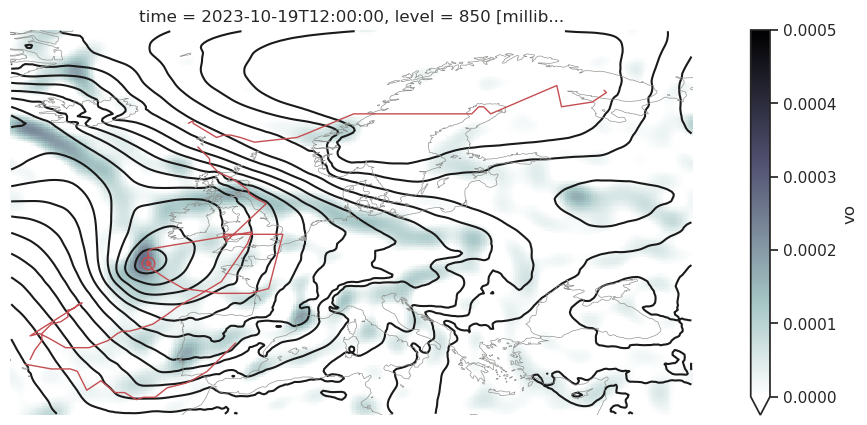

In [132]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(15,5))

choose_time='2023-10-19 12'
contours = 'msl'

if contours == 'msl':
    field_in.sel(time=choose_time).vo.plot(ax=ax,cmap='bone_r',vmin=0,vmax=5e-4)
    field_in.sel(time=choose_time).msl.plot.contour(ax=ax,levels=np.arange(95000,102000,400),colors='k')
    
else:
    field_in.sel(time=choose_time).msl.plot(ax=ax,cmap='bone',vmin=95000,vmax=102000)
    field_in.sel(time=choose_time).vo.plot.contour(ax=ax,levels=np.arange(1e-4,6e-4,1e-4),colors='k')


nodes_out.loc[nodes_out.date==choose_time].plot.scatter('lon','lat',
                                                        color='r',
                                                        s=9,
                                                        ax=ax,
                                                        marker='o')
tracks_out.loc[tracks_out.date==choose_time,['lon','lat']].plot('lon','lat',
                                                                ax=ax,
                                                                ms=9,
                                                                marker='o',
                                                                mec='r',
                                                                mfc='none',
                                                                lw=0, 
                                                                legend=False)
g=sns.lineplot(data=tracks_out.loc[(tracks_out.date>'2023-10-12')&(tracks_out.date<'2023-10-24')],
               x='lon',
               y='lat',
               size='track_id',
               sizes=(1,1),
               color='r',
               legend=False,
               ax=ax,
               estimator=None,
               zorder=11,
               sort=False)

ax.coastlines(color='xkcd:grey',lw=0.5,zorder=10)
ax.axis('off')

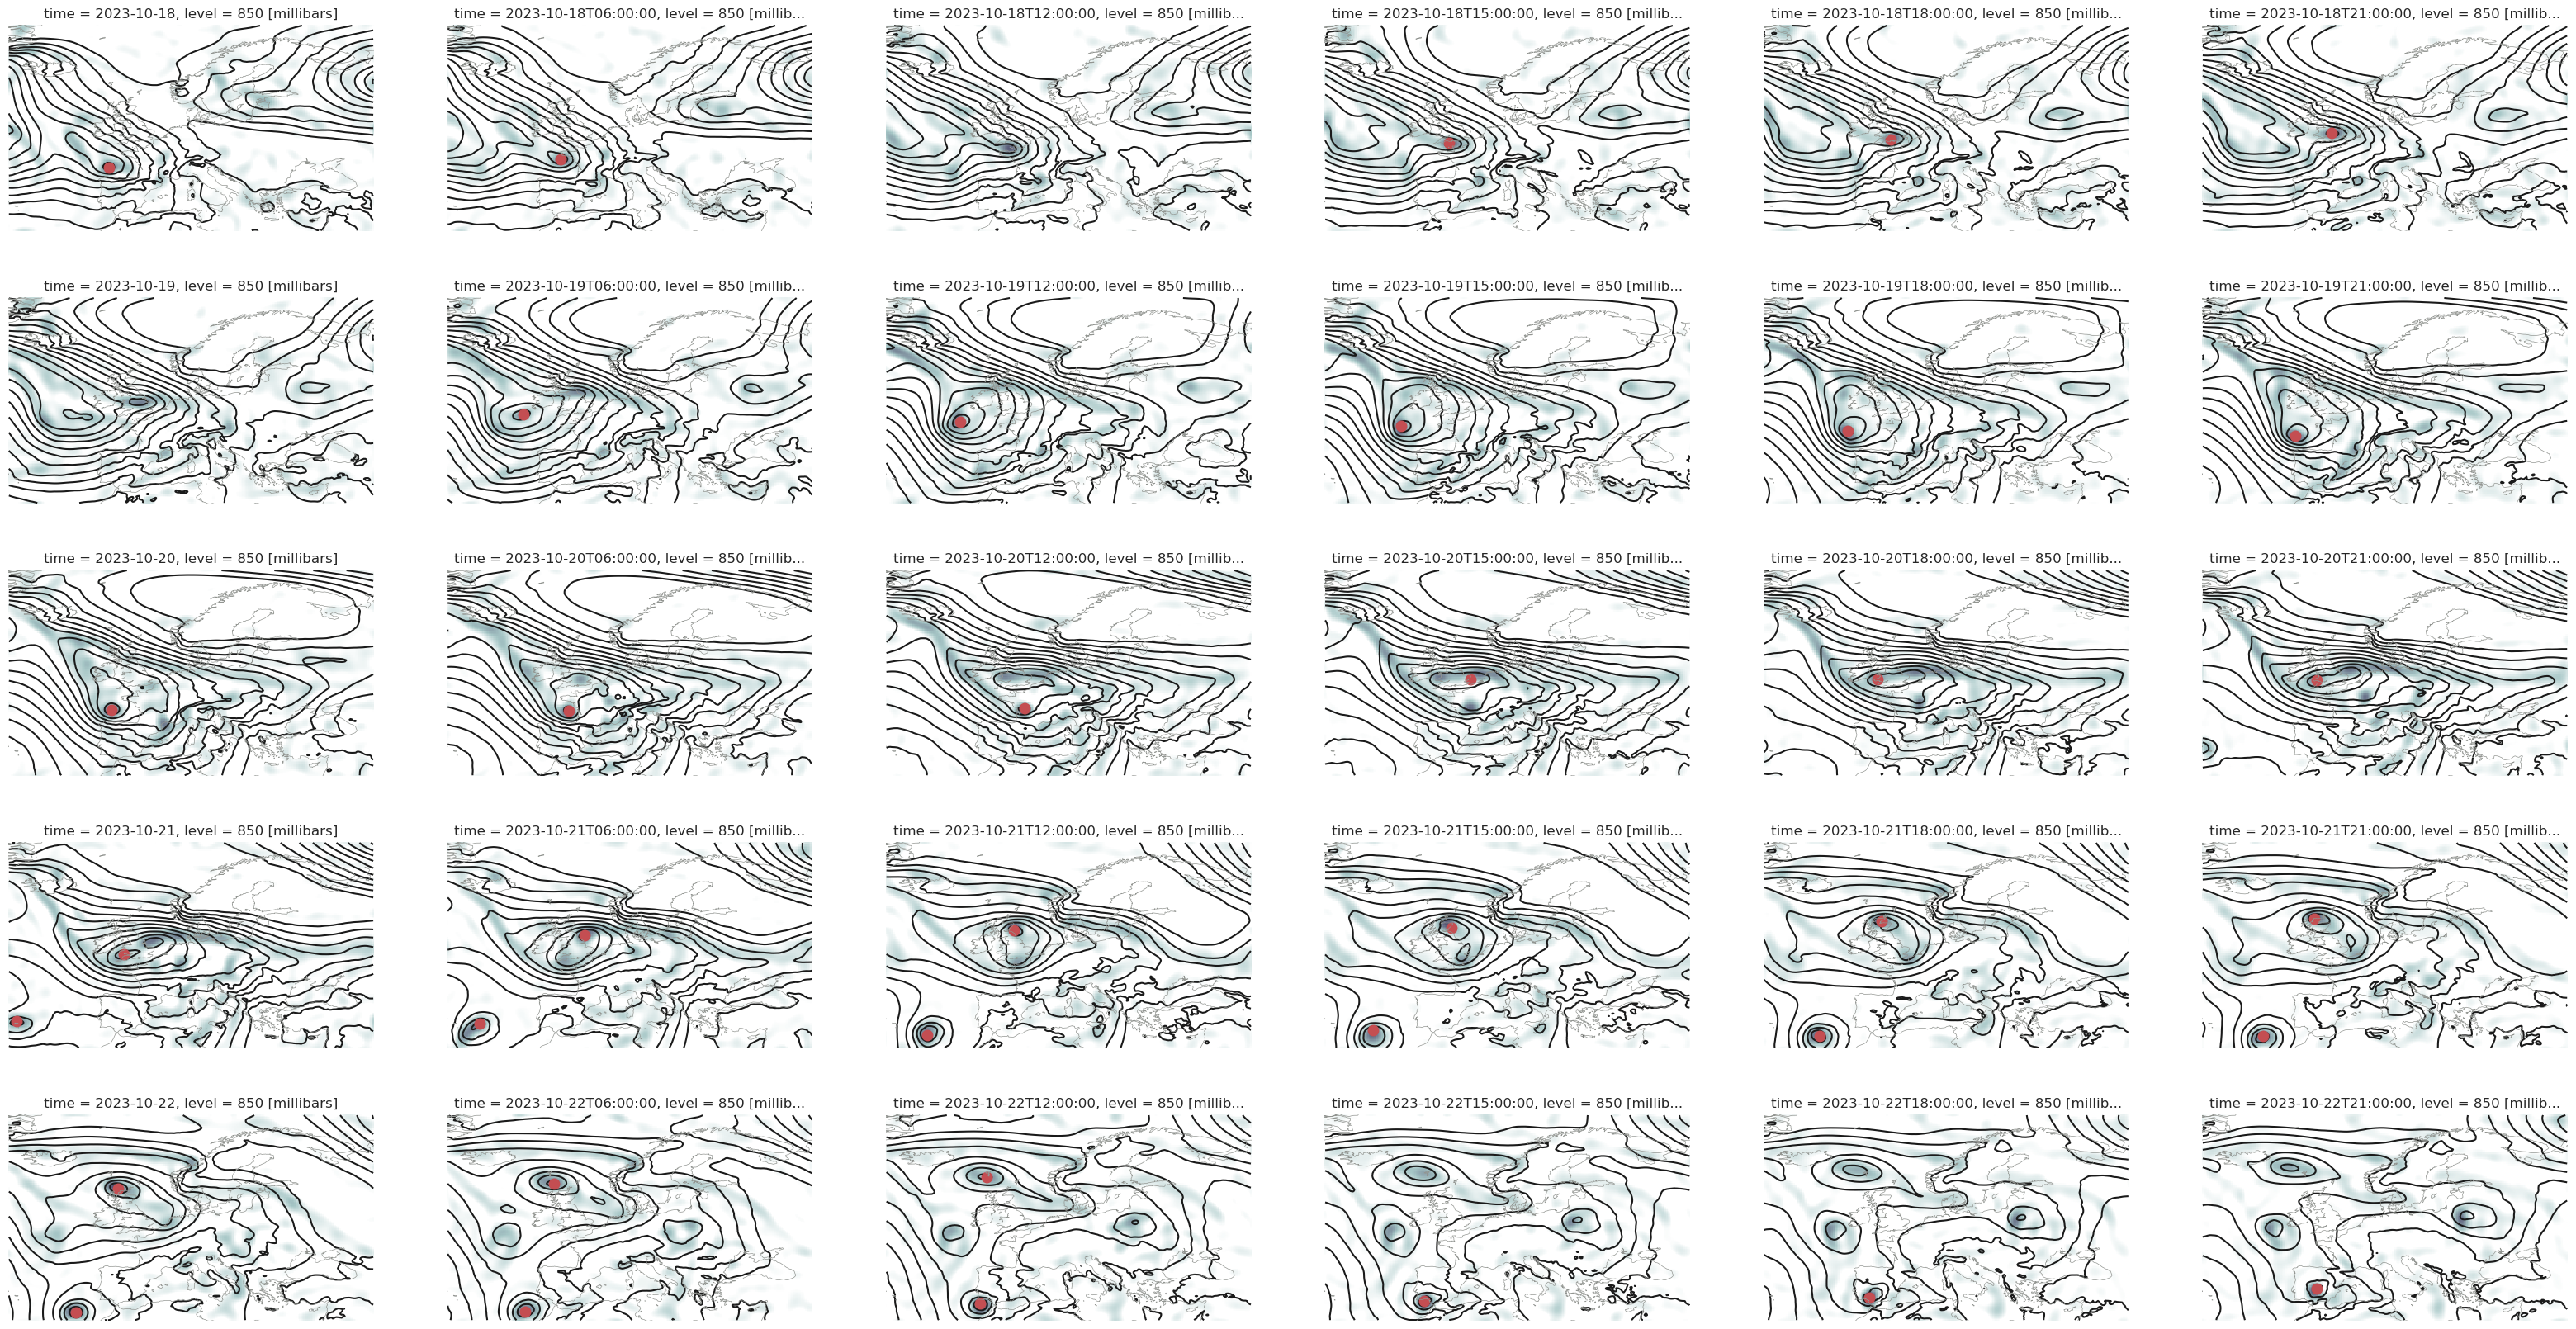

In [130]:
times = ['2023-10-18 00', '2023-10-18 06', '2023-10-18 12', '2023-10-18 15', '2023-10-18 18', '2023-10-18 21',
         '2023-10-19 00', '2023-10-19 06', '2023-10-19 12', '2023-10-19 15', '2023-10-19 18', '2023-10-19 21',
         '2023-10-20 00', '2023-10-20 06', '2023-10-20 12', '2023-10-20 15', '2023-10-20 18', '2023-10-20 21',
         '2023-10-21 00', '2023-10-21 06', '2023-10-21 12', '2023-10-21 15', '2023-10-21 18', '2023-10-21 21',
         '2023-10-22 00', '2023-10-22 06', '2023-10-22 12', '2023-10-22 15', '2023-10-22 18', '2023-10-22 21']
plt.figure(figsize=(40,25))
for i, time in enumerate(times):
    ax = plt.subplot(6,6,i+1,projection=ccrs.PlateCarree())
    field_in.sel(time=time).vo.plot(cmap='bone_r',vmin=0,vmax=5e-4,ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    field_in.sel(time=time).msl.plot.contour(ax=ax,levels=np.arange(95000,102000,400),colors='k', transform=ccrs.PlateCarree(), add_colorbar=False)
    tracks_out.loc[tracks_out.date==time,['lon','lat']].plot('lon','lat',
                                                                ax=ax,
                                                                ms=9,
                                                                marker='o',
                                                                mec='r',
                                                                mfc='r',
                                                                lw=0,
                                                                legend=False)
    ax.coastlines(color='xkcd:grey',lw=0.5,zorder=10)
    ax.axis('off')